### Introduction
In this project,we use autoencoder to both denoise and compress the Channel State Information (CSI). We follow the principle and methods in [CSInet](https://ieeexplore.ieee.org/document/8322184). Downlink CSI feedback is very imoprtant for exploiting the MIMO scheme in the Base Station (BS) and for massive MIMO systems, the feedback increases overhead that use up limited resources. Compressing the CSI using encoder in the UE end into a smaller dimension Latent Space allows efficeint transmission of the CSI which can then be reconstructed on the BS end using the decoder.

We assume a MIMO system with $N_t>>1$ transmit antennas at the BS and single receive antenna at the UE and the system is operated in $\widehat{N}_c$ subcarriers. So the CSI in the spatial frequency domain can be represented as $\widehat{\mathbf{H}}\in\mathbb{C}^{\widehat{N}_c\times N_t}$. $\widehat{\mathbf{H}}$ can be sparsified into angle delay domain by DFT transformation: $\mathbf{H}=\mathbf{F}_d\widehat{\mathbf{H}}\mathbf{F}_a^H$. Where, $\mathbf{F}_d$ and $\mathbf{F}_a$. $\mathbf{H}$ contains small fraction of large components so only the first $N_c$ rows are kept which means the final matrix has $2\times N_c \times N_t$ entries (considering real and complex values).

In [1]:
import tensorflow as tf
from keras.models import Model
import scipy.io as sio 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, losses

### Data
The data used here was generated in [CSInet](https://ieeexplore.ieee.org/document/8322184) where the authors used COST 2100 channel model for both indoor picocelular (5.3GHz) and outdoor rural (300MHz) scenario. Here $N_t=32$ and $\widehat{N}_c=1024$ and after converting it to angular delay domain $N_c=32$ was set. Which means each CSI matrix $\mathbf{H}$ has $32\times32\times2=2048$ entries.Training, validation and testing sets have $100,000$, $30,000$ and $20,000$ realizations for both scenarios.

In [2]:
envir = 'indoor' #'indoor' or 'outdoor'
# image params
img_height = 32
img_width = 32
img_channels = 2 
img_total = img_height*img_width*img_channels
# network params
LS_dim = 512
#total dim = 2048

# Data loading
if envir == 'indoor':
    mat = sio.loadmat('data/DATA_Htrainin.mat') 
    x_train = mat['HT']
    mat = sio.loadmat('data/DATA_Hvalin.mat')
    x_val = mat['HT']
    mat = sio.loadmat('data/DATA_Htestin.mat')
    x_test = mat['HT']

elif envir == 'outdoor':
    mat = sio.loadmat('data/DATA_Htrainout.mat') 
    x_train = mat['HT']
    mat = sio.loadmat('data/DATA_Hvalout.mat')
    x_val = mat['HT']
    mat = sio.loadmat('data/DATA_Htestout.mat')
    x_test = mat['HT']

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train = np.reshape(x_train, (len(x_train), img_channels, img_height, img_width))
x_val = np.reshape(x_val, (len(x_val), img_channels, img_height, img_width))
x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))

x_train=np.moveaxis(x_train,1,3)
x_val=np.moveaxis(x_val,1,3)
x_test=np.moveaxis(x_test,1,3)

noise_factor = 0.05
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_val_noisy = x_val + noise_factor * tf.random.normal(shape=x_val.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_val_noisy = tf.clip_by_value(x_val_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

### Model 1
Convolutional Neural Network (CNN) based autoencoder was used. The CSI matrix $\mathbf{H}$ was considered as a two channel image (real and imaginary). Layers use $3\times3$ kernels and different depthes of convulutional layers were used. For the decoder, similar networks in reverse were used. Independant random Gaussian noise were used to corrupt the data. During traing, noisy $\mathbf{H}$ were used as encoder input and clean $\mathbf{H}$ were used as decoder output. For loss function mean squared logarithmic error was used.

In [3]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(img_height, img_width, img_channels)),
        layers.Conv2D(16, (3, 3), activation=None, padding='same', strides=2),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=1),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(16, (3, 3), activation=None, padding='same', strides=1),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(8, (3, 3), activation=None, padding='same', strides=2),
        layers.BatchNormalization(),
        layers.LeakyReLU()
          ])
    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, activation='relu', padding='same', strides=2),
        layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same', strides=1),
        layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same', strides=1),
        layers.Conv2DTranspose(64, kernel_size=3, activation='relu', padding='same', strides=1),
        layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same', strides=1),
        layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same', strides=2),
        layers.Conv2D(2, kernel_size=(3, 3), activation='sigmoid', padding='same')])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredLogarithmicError())

In [4]:
# autoencoder.fit(x_train_noisy, x_train,
#                epochs=50,
#                batch_size=50,
#                shuffle=True,
#                validation_data=(x_test_noisy, x_test))

In [5]:
outfile='my_models/model_a'
# autoencoder.save_weights(outfile)
autoencoder.load_weights(outfile)
# autoencoder.encoder.summary()
# autoencoder.decoder.summary()

encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

score = autoencoder.evaluate(x_test_noisy, x_test, verbose = 0) 

C:\Users\root.HUA-LAB-021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: vmin, vmax. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

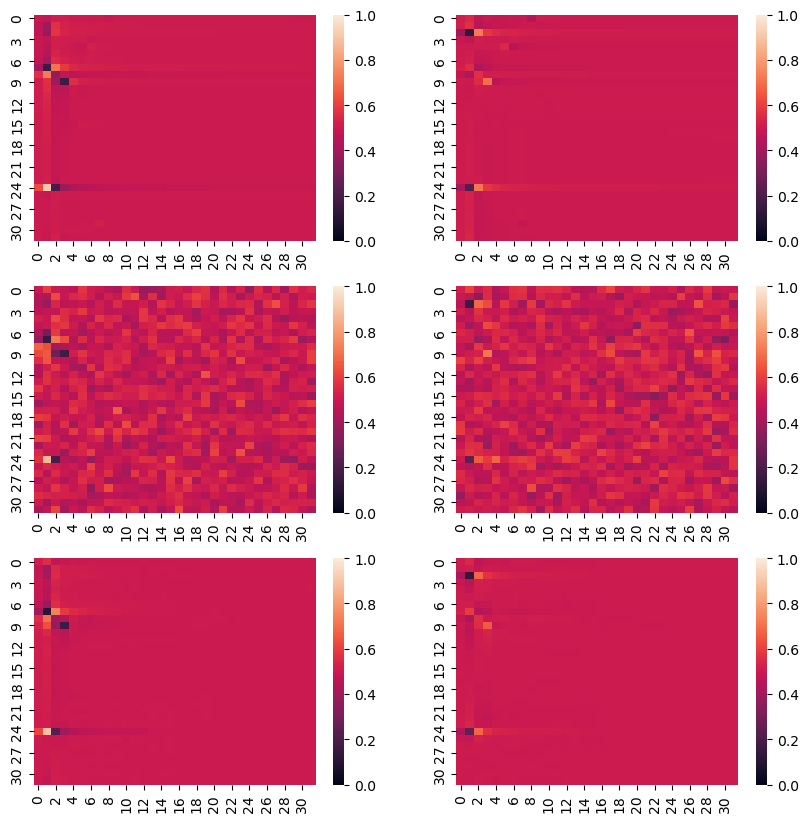

In [6]:
i=np.random.randint(len(x_test))
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

sns.heatmap(x_test[i,:,:,0],0,1,ax=axes[0, 0])
sns.heatmap(x_test[i,:,:,1],0,1,ax=axes[0, 1])

sns.heatmap(x_test_noisy[i,:,:,0],0,1,ax=axes[1, 0])
sns.heatmap(x_test_noisy[i,:,:,1],0,1,ax=axes[1, 1])

sns.heatmap(decoded_imgs[i,:,:,0],0,1,ax=axes[2, 0])
sns.heatmap(decoded_imgs[i,:,:,1],0,1,ax=axes[2, 1])

### Error Analysis
After the inference of the training data, we evaluate the error as Mean Squared Error $MSE = \mathbb{E}[ (X-X')^2 ]$

In [7]:
err_noisy = ((x_test-x_test_noisy)**2)
err_recon = ((x_test-decoded_imgs)**2)
print('MSE of noisy CSI:', tf.reduce_mean(err_noisy))
print('MSE of reconstructed CSI:', tf.reduce_mean(err_recon))

MSE of noisy CSI: tf.Tensor(0.002499722, shape=(), dtype=float32)
MSE of reconstructed CSI: tf.Tensor(6.486782e-05, shape=(), dtype=float32)


### Another model to test
### Model 2
Using shallower network

In [8]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(img_height, img_width, img_channels)),
        layers.Conv2D(16, (3, 3), activation=None, padding='same', strides=2),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
#         layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(),
#         layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=1),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(),
#         layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(),
        layers.Conv2D(16, (3, 3), activation=None, padding='same', strides=1),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(8, (3, 3), activation=None, padding='same', strides=2),
        layers.BatchNormalization(),
        layers.LeakyReLU()
          ])
    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, activation='relu', padding='same', strides=2),
        layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same', strides=1),
#         layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same', strides=1),
#         layers.Conv2DTranspose(64, kernel_size=3, activation='relu', padding='same', strides=1),
#         layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same', strides=1),
        layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same', strides=2),
        layers.Conv2D(2, kernel_size=(3, 3), activation='sigmoid', padding='same')])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredLogarithmicError())

# autoencoder.fit(x_train_noisy, x_train,
#                epochs=50,
#                batch_size=50,
#                shuffle=True,
#                validation_data=(x_test_noisy, x_test))
outfile='my_models/model_b'
# autoencoder.save_weights(outfile)
autoencoder.load_weights(outfile)
# autoencoder.encoder.summary()
# autoencoder.decoder.summary()

encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

score = autoencoder.evaluate(x_test_noisy, x_test, verbose = 0) 

err_noisy = ((x_test-x_test_noisy)**2)
err_recon = ((x_test-decoded_imgs)**2)
print('MSE of noisy CSI:', tf.reduce_mean(err_noisy))
print('MSE of reconstructed CSI:', tf.reduce_mean(err_recon))

MSE of noisy CSI: tf.Tensor(0.002499722, shape=(), dtype=float32)
MSE of reconstructed CSI: tf.Tensor(0.00010833822, shape=(), dtype=float32)


<AxesSubplot:>

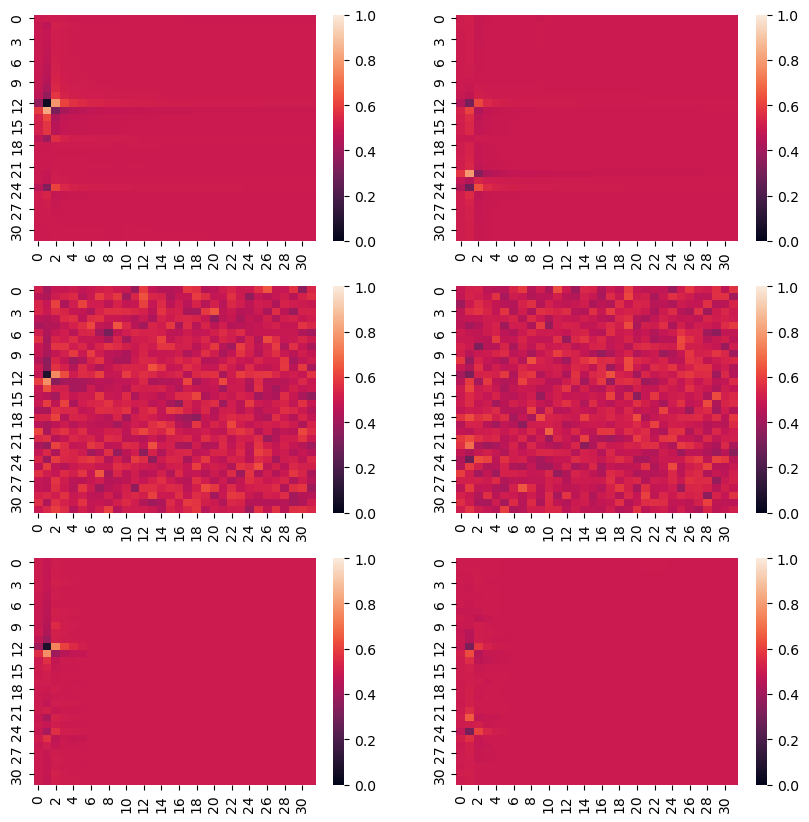

In [9]:
i=np.random.randint(len(x_test))
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

sns.heatmap(x_test[i,:,:,0],0,1,ax=axes[0, 0])
sns.heatmap(x_test[i,:,:,1],0,1,ax=axes[0, 1])

sns.heatmap(x_test_noisy[i,:,:,0],0,1,ax=axes[1, 0])
sns.heatmap(x_test_noisy[i,:,:,1],0,1,ax=axes[1, 1])

sns.heatmap(decoded_imgs[i,:,:,0],0,1,ax=axes[2, 0])
sns.heatmap(decoded_imgs[i,:,:,1],0,1,ax=axes[2, 1])

### Model 3
using MSE as loss function

In [10]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(img_height, img_width, img_channels)),
        layers.Conv2D(16, (3, 3), activation=None, padding='same', strides=2),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(64, (3, 3), activation=None, padding='same', strides=1),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(32, (3, 3), activation=None, padding='same', strides=1),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(16, (3, 3), activation=None, padding='same', strides=1),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(8, (3, 3), activation=None, padding='same', strides=2),
        layers.BatchNormalization(),
        layers.LeakyReLU()
          ])
    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, activation='relu', padding='same', strides=2),
        layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same', strides=1),
        layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same', strides=1),
        layers.Conv2DTranspose(64, kernel_size=3, activation='relu', padding='same', strides=1),
        layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same', strides=1),
        layers.Conv2DTranspose(16, kernel_size=3, activation='relu', padding='same', strides=2),
        layers.Conv2D(2, kernel_size=(3, 3), activation='sigmoid', padding='same')])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# autoencoder.fit(x_train_noisy, x_train,
#                epochs=50,
#                batch_size=50,
#                shuffle=True,
#                validation_data=(x_test_noisy, x_test))
outfile='my_models/model_c'
# autoencoder.save_weights(outfile)
autoencoder.load_weights(outfile)
# autoencoder.encoder.summary()
# autoencoder.decoder.summary()

encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

score = autoencoder.evaluate(x_test_noisy, x_test, verbose = 0) 

err_noisy = ((x_test-x_test_noisy)**2)
err_recon = ((x_test-decoded_imgs)**2)
print('MSE of noisy CSI:', tf.reduce_mean(err_noisy))
print('MSE of reconstructed CSI:', tf.reduce_mean(err_recon))

MSE of noisy CSI: tf.Tensor(0.002499722, shape=(), dtype=float32)
MSE of reconstructed CSI: tf.Tensor(6.252324e-05, shape=(), dtype=float32)


<AxesSubplot:>

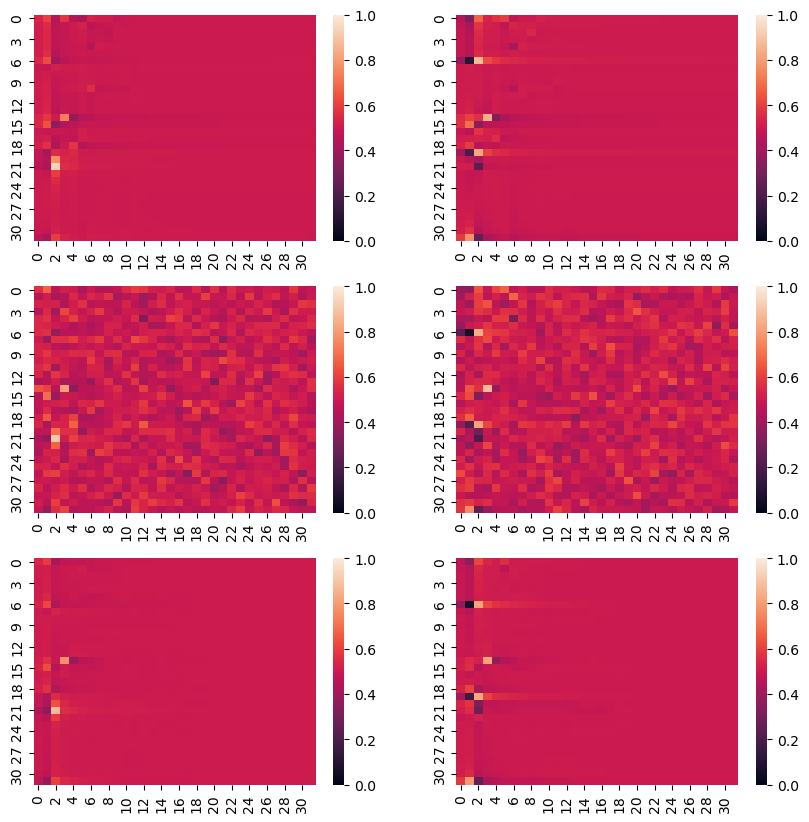

In [11]:
i=np.random.randint(len(x_test))
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

sns.heatmap(x_test[i,:,:,0],0,1,ax=axes[0, 0])
sns.heatmap(x_test[i,:,:,1],0,1,ax=axes[0, 1])

sns.heatmap(x_test_noisy[i,:,:,0],0,1,ax=axes[1, 0])
sns.heatmap(x_test_noisy[i,:,:,1],0,1,ax=axes[1, 1])

sns.heatmap(decoded_imgs[i,:,:,0],0,1,ax=axes[2, 0])
sns.heatmap(decoded_imgs[i,:,:,1],0,1,ax=axes[2, 1])